<a href="https://colab.research.google.com/github/gregor-posadas/Gregor-Projects/blob/main/mod05_1D_Advection_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 04: Advection Dominated Systems Assignment

## Overview and Requirements

___DISASTER!___ An earthquake has resulted in a partial meltdown of a nuclear reactor and the contamination of that reactor's cooling water tanks. The reactor automatically scrammed and the reactor hall was safe enough that the fuel rods were removed, but not before a significant leak of radioactive Cesium into the water stored in the tanks. Cs-137 is highly soluble in water and so the whole tank is effectively uniformly contaminated. What's worse, the earthquake also ruptured the cooling water tanks and contaminated water is now leaking into the aquifer. The location of the rupture is such that it is too dangerous to repair.

Your job as a consultant is to conduct a "worst case" scenario modeling study in which the tank will continue to drain contaminated water into the aquifer at a constant rate of 0.05% of its volume per year. The aquifer is an unconfined aquifer that has a saturated hydraulic conductivity ($K_s$) of 15.0 cm/day and a constant regional head gradient $\partial h/\partial t$ of 30.0 ft/mile.

Using your trusy advection-dominated code your wrote as a graduate student at Boise State, you know you can simply modify the boundary conditions to your model to examine the impact. Your solution notebook you turn in should have code that produces the following plots:

* The concentration of the contaminant of the aquifer at the contamination site
* Concentration profiles (concentration vs. distance) at every 50th time step of the simulation
* The plot showing the evolution of concentration as a function of both distance from the contamination site and time
* The breakthrough curve (concentration vs. time) at a location x = 1500 m

Answer the following questions:
* What time step did you have to select to get the Courant number as close to 1.0 as possible?
* If you were to have to describe what was going to happen to the water quality at the town located 1.5 km from the contamination site, how would you describe in words how the water quality will behave in the future?
* If concentrations below 0.05 GBq/g are considered safe for drinking water quallity, at the town 1.5 km away from the contamination site, how many years in the future will it take the contamination plume to arrive? And how long will the water be unusable?


In [148]:
import numpy as np
import matplotlib.pyplot as plt

dx = 5.0  # Spatial interval [m] - DON'T CHANGE
dt = 10.00    # Time step [yr]

# Fraction of initial tank volume lost each year [yr-1]
k_tank = 0.0005

xmin = 0.0 # Origin: Contamination site
xmax = 4000.0 # Edge of the domain

t0 = 0.0 # Time that the tank broke
tf = 10000.0 # End of simulation time

Ks = 15.0 # Saturated hydraylic conductivity [cm/day]
dhdx = 30.0 # Regional piezometric gradient [ft/mi]

Ks = Ks/100.0*365.25 # Converting Ks from [cm/day] to [m/yr]
dhdx = dhdx*(1/5280.0)

In [149]:
q = Ks*dhdx

print('The Darcy velocity is ' + '{:.3f}'.format(q) + ' [m/yr]')

The Darcy velocity is 0.311 [m/yr]


In [150]:
x = np.arange(xmin+dx/2, xmax, dx)
Nx = x.size

print('The number of cells is: Nx = ' + str(Nx))

The number of cells is: Nx = 800


In [152]:
t = np.arange(t0,tf+dt,dt)
Nt = t.size
print('The number of time steps: Nt = ' + str(Nt))

The number of time steps: Nt = 1001


In [153]:
Courant = q*(dt/dx)

print('The Courant number is ' + '{:.3f}'.format(Courant)+'. The optimal number is 1 to avoid numerical diffusion. Consider changing dt')

The Courant number is 0.623. The optimal number is 1 to avoid numerical diffusion. Consider changing dt


### Setup Initial and Boundary Conditions

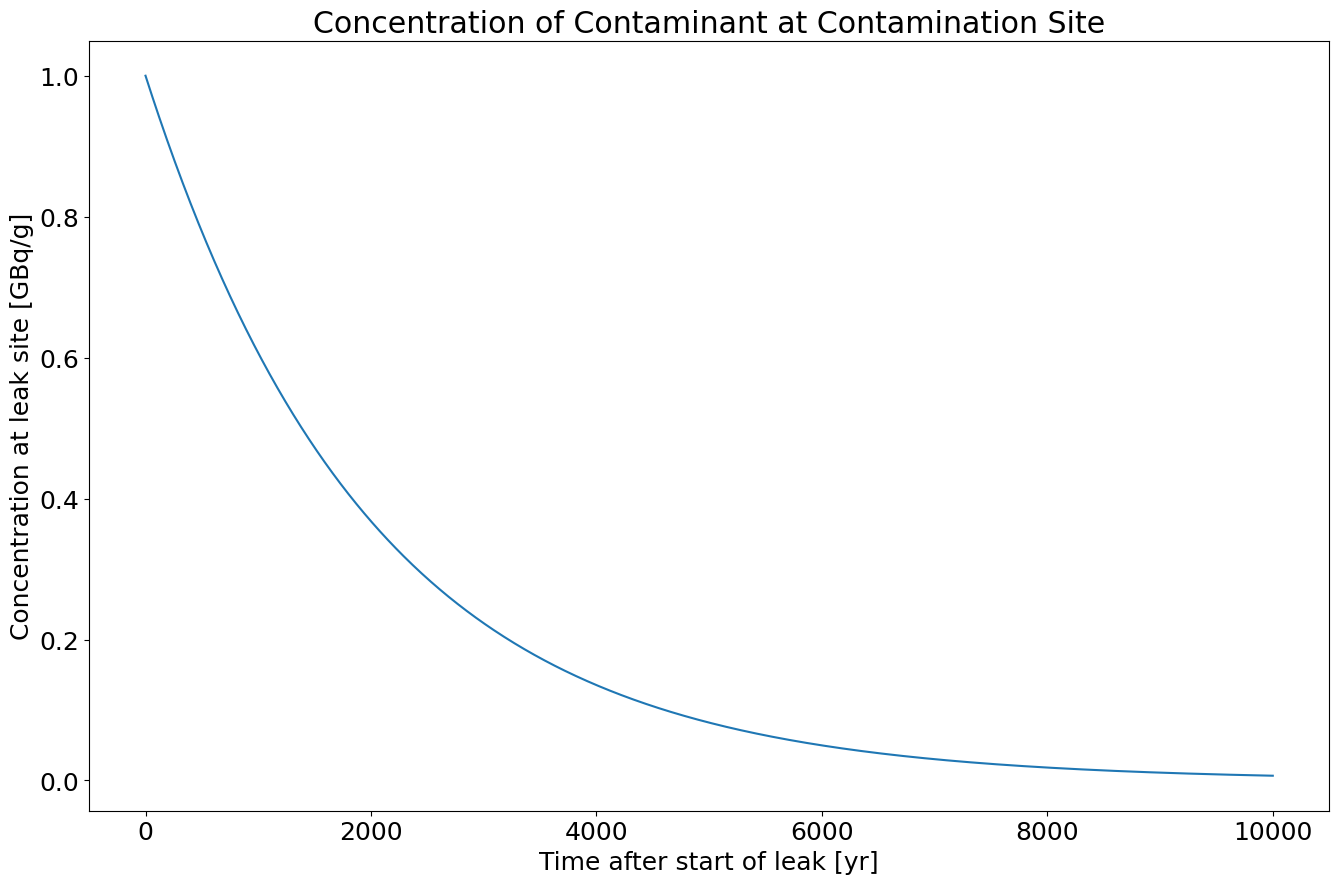

In [154]:
# Initial condition: concentration is 0 GBq/g everywhere except at x = 0,
# where it is 1 Bq/g
c0 = np.zeros((Nx,1))
c0[0] = 1

# Boundary condition: concentration decreases at a rate of k_tank [yr-1]
csource = c0[0] * np.exp(-k_tank * t)  #Added this line of code for the Boundary Condition

plt.figure(figsize=(16,10))
plt.rcParams.update({'font.size': 18})
plt.title('Concentration of Contaminant at Contamination Site')
plt.plot(t, csource)
plt.xlabel('Time after start of leak [yr]')
plt.ylabel('Concentration at leak site [GBq/g]')
plt.show()

### Preallocate Container for Solution

In [155]:
C = np.zeros((Nx,Nt))


### Compute Solution

In [156]:
for i in np.arange(Nt):

    # Get initial conditions
    if (i==0):
        Cprev = c0
    else:
        Cprev = C[:,i-1]

    Cnext = np.zeros((Nx))

    for j in np.arange(Nx):

        if (j==0):
          # Apply boundary condition with decay at contamination site
            Cnext[j] = Cprev[j] * (1 - k_tank * dt)

        else:
          # Apply upwind scheme for advection and include decay
            adv_flux = -q * (Cprev[j] - Cprev[j - 1]) / dx
            decay_flux = -k_tank * Cprev[j]
            Cnext[j] = Cprev[j] + dt * (adv_flux + decay_flux)


    C[:,i] = Cnext

<ipython-input-156-069ca5c22c76>:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cnext[j] = Cprev[j] * (1 - k_tank * dt)
<ipython-input-156-069ca5c22c76>:21: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Cnext[j] = Cprev[j] + dt * (adv_flux + decay_flux)


### Plot solutions

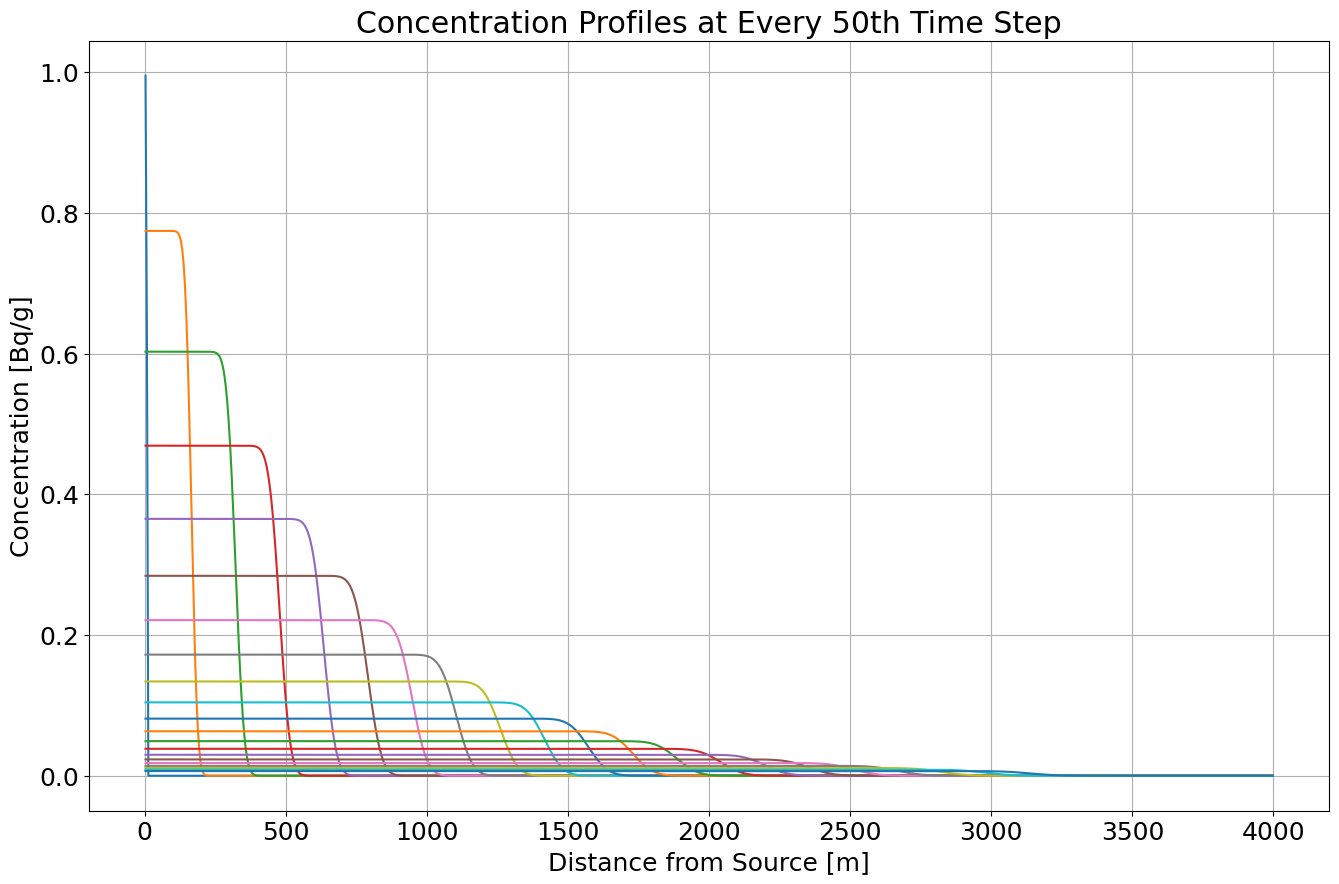

In [157]:
# Plot concentration profiles (concentration vs. distance) at every 50th time step
## First off, let's change the font size for all of our plots to be more legible
plt.figure(figsize=(16, 10))
for i in range(0, Nt, 50):  # Plot every 50th time step
    plt.plot(x, C[:, i], label=f'Time step {i}')
plt.xlabel('Distance from Source [m]')
plt.ylabel('Concentration [Bq/g]')
plt.title('Concentration Profiles at Every 50th Time Step')
plt.grid(True)
plt.show()

# Not entirely sure why this looks so different from what was included in the original code of the assignment file.
# If the contaminant were being advected, it should be that concentrations would be spiking exponentially, then dropping gradually at every time step.

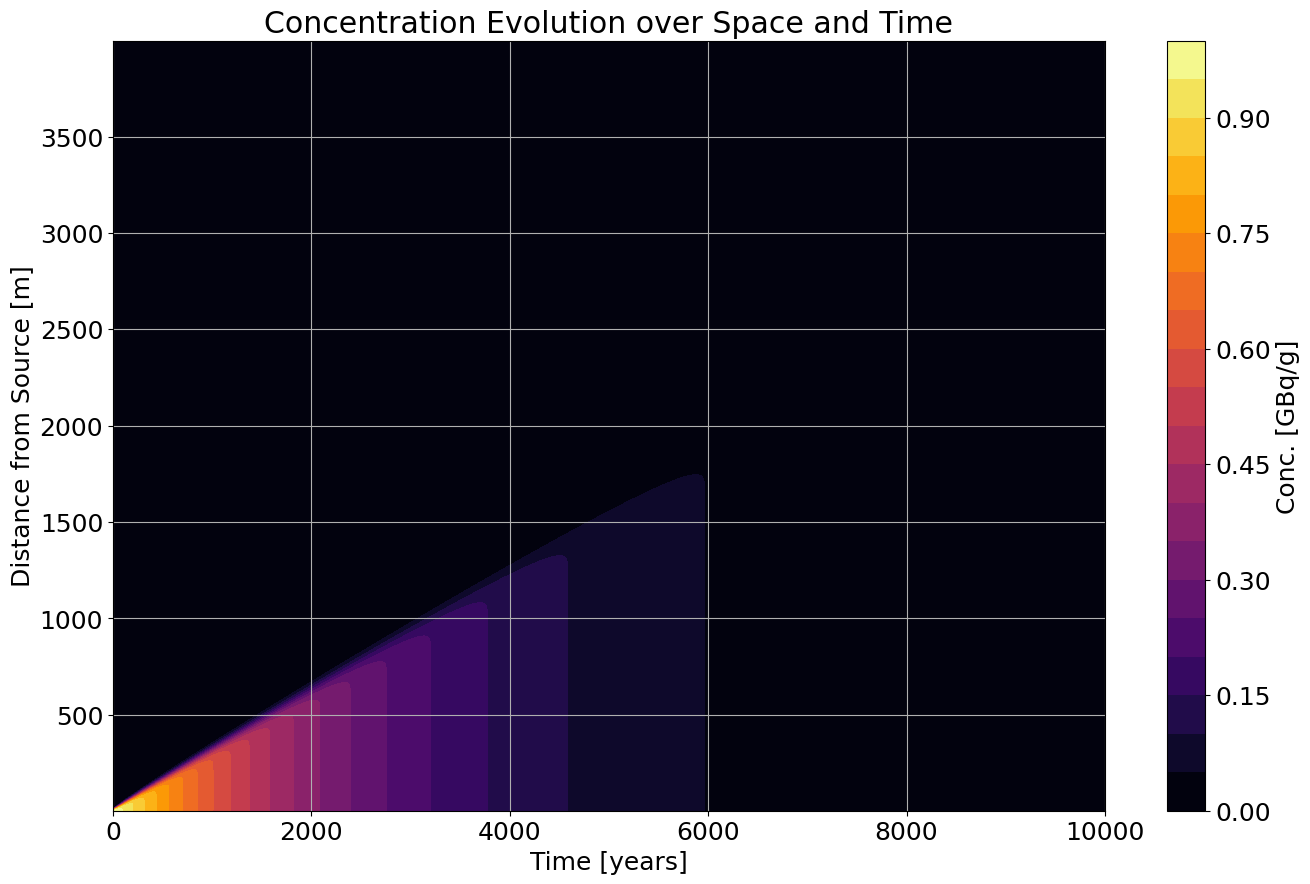

In [158]:
xx, tt = np.meshgrid(t, x)
plt.figure(figsize=(16, 10))
plt.contourf(xx, tt, C, levels=20, cmap='inferno')
plt.colorbar(label='Conc. [GBq/g]')
plt.xlabel('Time [years]')
plt.ylabel('Distance from Source [m]')
plt.title('Concentration Evolution over Space and Time')
plt.grid(True)
plt.show()

# **Breakthrough Curve (Concentration vs. Time) at a Location**

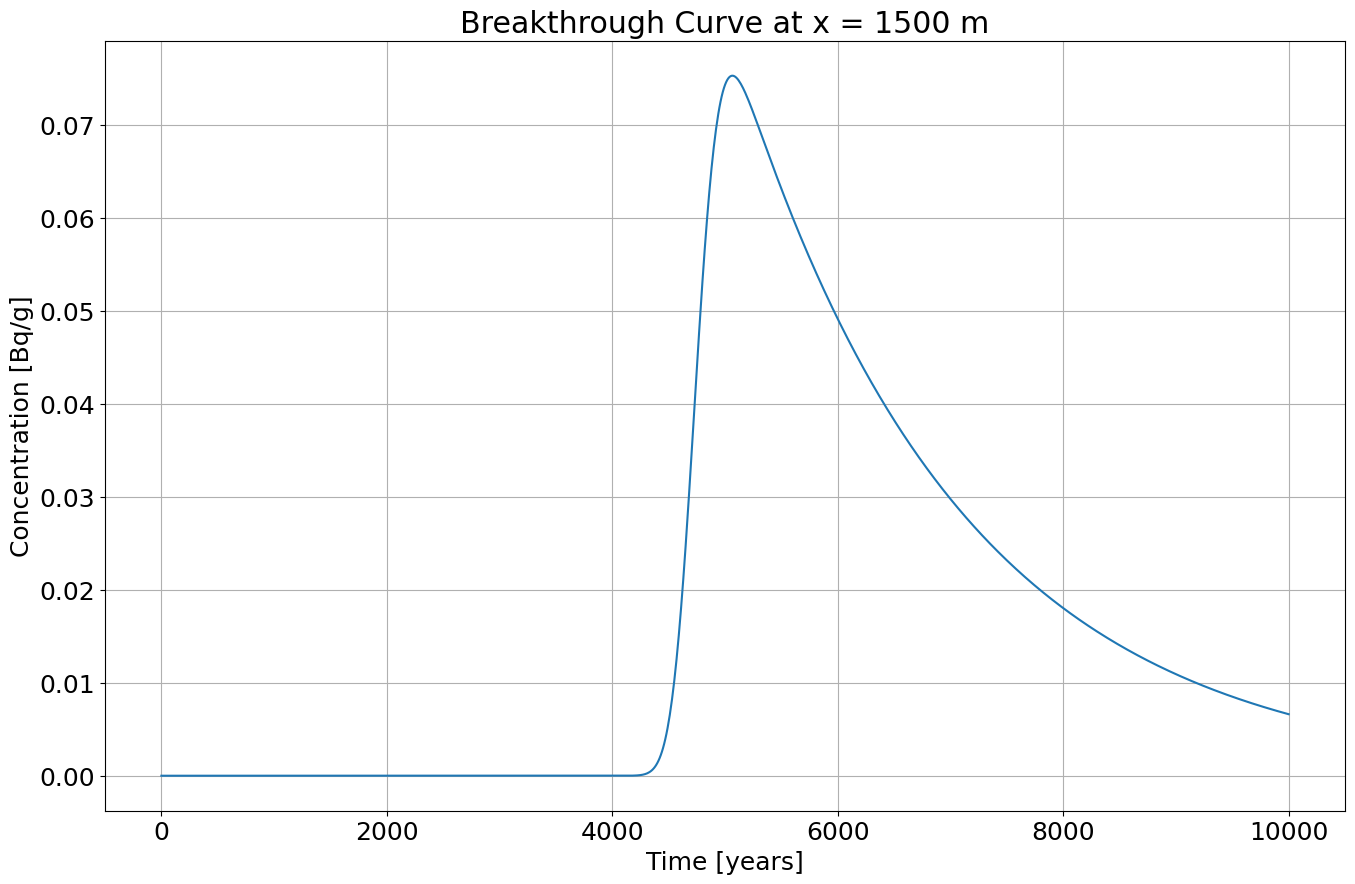

In [159]:
# Plot breakthrough curve at x = 1500 m
x_location_index = np.argmin(np.abs(x - 1500))  # Find the index closest to x = 1500 m
plt.figure(figsize=(16, 10))
plt.plot(t, C[x_location_index, :], label='Breakthrough curve at x = 1500 m')
plt.xlabel('Time [years]')
plt.ylabel('Concentration [Bq/g]')
plt.title('Breakthrough Curve at x = 1500 m')
plt.grid(True)
plt.show()

1. The time step I used to get as close to a Courant Number of 1.0 was 10. Realistically when I back calculated what dt had to be in order to get a courant of 1.0, it was supposed to be dt = 16.05. However, when I did this, the Concentration Profiles plot (for every 50th time step) looked weird and I assume this was due to numerical instability. This did not make sense to me since I assumed getting a courant closer to 1.0 would be better for the model, but I guess it's how my plot is set up.

2. At a town located 1.5 km (1500 m) from the contamination site, the concentration of the contaminant will gradually increase as the plume reaches that point. There will be an initial delay before the contaminant arrives. Once the plume reaches the town, there will be an exponential increase in concentration, followed by a gradual decay as the plume moves further downstream and decay continues. Initially, the water quality will be unaffected, then deteriorate significantly, and eventually improve as the contaminant disperses and decays.

3. It looks like it will take between 4500 to 5000 years for a contaminant concentration exceeding the safe drinking water level to reach the town (based visually on the Breakthrough curve plot).